In [1]:
from pathlib import Path
import rasterio

from rasterio.plot import show
import rasterio.mask
import pyproj
import shapely
import shapely.geometry
import shapely.ops
import fiona
import numpy as np
import geopandas as gpd
from IPython.display import display

# Mask

In [2]:
def reproject_geom(geom, src_crs, dst_crs):
    transformer = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    return shapely.ops.transform(transformer.transform, geom)

In [3]:
src = rasterio.open("data/raster/example.tif")

In [4]:
src.shape

(1667, 1909)

In [5]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1909, 'height': 1667, 'count': 1, 'crs': CRS.from_wkt('COMPD_CS["NAD83(CSRS) / UTM zone 12N + CGVD2013 height",PROJCS["NAD83(CSRS) / UTM zone 12N + CGVD2013 height",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]],VERT_CS["CGVD2013(CGG2013) height",VERT_DATUM["Canadian Geodetic Vertical Datum of 2013 (CGG2013)",2005,AUTHORITY["EPSG","1127"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Up",UP]]]'), 'transform': Affine(5.0,

In [6]:
boundary = gpd.read_file("data/vector/boundary.geojson").to_crs(src.crs)

In [7]:
mask_arr = src.read_masks(1)

In [8]:
boundary_arr = rasterio.features.rasterize(boundary.geometry, out_shape=src.shape, transform=src.transform, all_touched=False, dtype="uint8", fill=0, default_value=255)

In [9]:
boundary_arr.shape

(1667, 1909)

In [10]:
out = (mask_arr - boundary_arr).astype("bool")

In [11]:
out

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [12]:
out.shape

(1667, 1909)

In [13]:
out.any()

np.True_

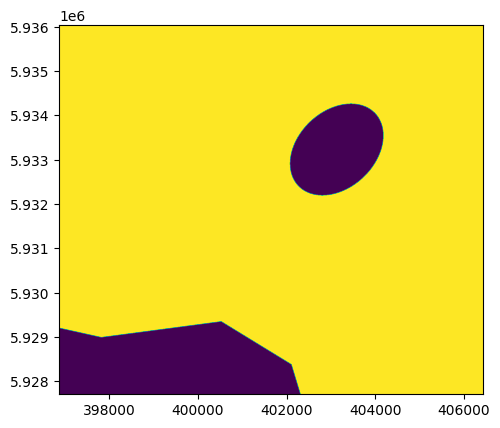

<Axes: >

In [14]:
show(mask_arr, transform=src.transform)

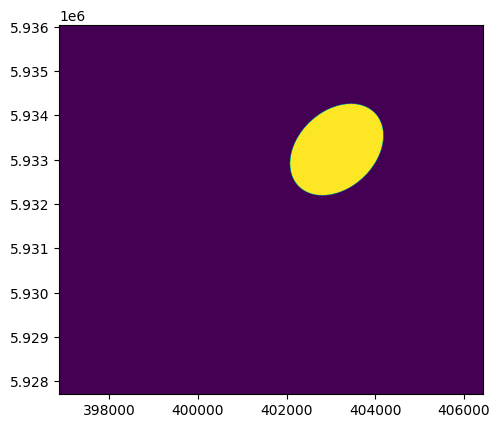

<Axes: >

In [15]:
show(out, transform=src.transform)

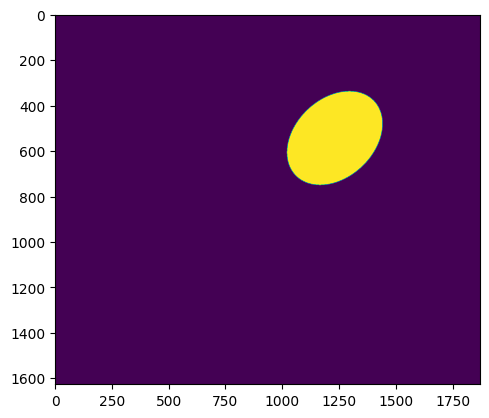

<Axes: >

In [16]:
clip_amount = 20
show(out[clip_amount:out.shape[0]-clip_amount, clip_amount:out.shape[1]-clip_amount])

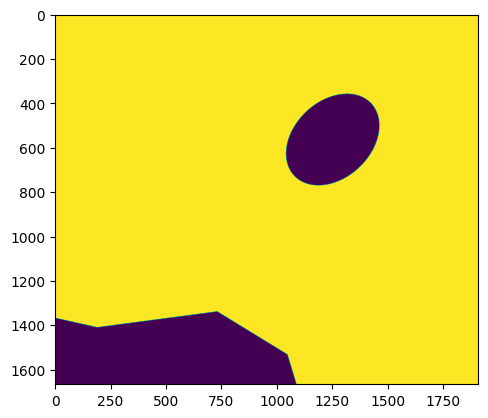

<Axes: >

In [17]:
show(src.read_masks(1))

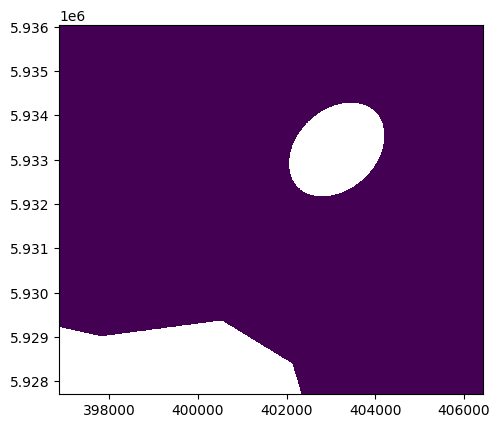

<Axes: >

In [18]:
show(src)

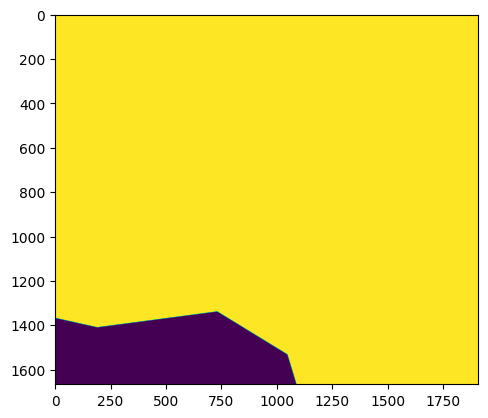

<Axes: >

In [19]:
show(boundary_arr)

# Polygonize

In [50]:
boundary_geom = boundary.iloc[0].geometry

In [ ]:
%%timeit
result = rasterio.features.shapes(src.read_masks(1), connectivity=8, transform=src.transform)
gs = gpd.GeoSeries([shapely.geometry.shape(geom) for geom, val in result if int(val) == 0], crs=src.crs)
print(boundary.contains(gs, align=True).any())
# for geom, val in result:
#     if int(val) == 0:
#         geom_int = boundary_geom.intersection(shapely.geometry.shape(geom))
#         print(geom_int.geom_type)
#         print(geom_int.area)
#         print(geom_int.is_valid)
#         print(boundary_geom.contains(geom_int))

In [3]:
def has_voids_polygonize(raster_filename: str, boundary_vector_filename: str, verbose: bool = False) -> bool:
    with rasterio.open(raster_filename) as src:
        boundary = gpd.read_file(boundary_vector_filename).to_crs(src.crs)
        shapes = rasterio.features.shapes(src.read_masks(1), connectivity=8, transform=src.transform)
        gs = gpd.GeoSeries([shapely.geometry.shape(geom) for geom, val in shapes if int(val) == 0], crs=src.crs)
        if verbose:
            gs.plot()
        return boundary.contains(gs, align=True).any()

In [4]:
def has_voids_mask(raster_filename: str, boundary_vector_filename: str, verbose: bool = False) -> bool:
    with rasterio.open(raster_filename) as src:
        boundary = gpd.read_file(boundary_vector_filename).to_crs(src.crs)
        boundary_arr = rasterio.features.rasterize(boundary.geometry, out_shape=src.shape, transform=src.transform, all_touched=True, dtype="uint8", fill=0, default_value=255)
        if verbose:
            show(src.read_masks(1) - boundary_arr, transform=src.transform)
        return (src.read_masks(1) - boundary_arr).any()

In [ ]:
def has_voids_geometry_mask(raster_filename: str, boundary_vector_filename: str, verbose: bool = False) -> bool:
    with rasterio.open(raster_filename) as src:
        boundary = gpd.read_file(boundary_vector_filename).to_crs(src.crs)
        boundary_arr = rasterio.features.geometry_mask(boundary.geometry, transform=src.transform, out_shape=src.shape, invert=False)
        if verbose:
            show(~(src.read_masks(1).astype('bool') ^ boundary_arr), transform=src.transform)
        
        return (~(src.read_masks(1).astype('bool') ^ boundary_arr))

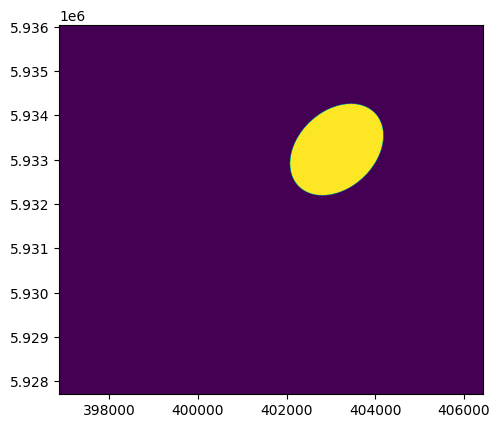

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[ 359 1310]
 [ 359 1311]
 [ 359 1312]
 ...
 [ 771 1187]
 [ 771 1188]
 [ 771 1189]]


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
has_voids_geometry_mask("data/raster/example.tif", "data/vector/boundary.geojson", verbose=True)

In [34]:
%timeit has_voids_mask("data/raster/example.tif", "data/vector/boundary.geojson")

11.4 ms ± 183 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%timeit has_voids_polygonize("data/raster/example.tif", "data/vector/boundary.geojson")

52.4 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%timeit has_voids_geometry_mask("data/raster/example.tif", "data/vector/boundary.geojson")

27.8 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Real world data

In [7]:
data_dir = Path("/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS")
boundary_filename = Path("/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/TILES/UTM_12N/14808_FullCorridor_b30m_z12.geojson")
rasters = list(data_dir.rglob("*.tif"))

In [8]:
print(rasters)

[PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_531_6040_18137_DTMHS.tif'), PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_371_5963_18137_DTMHS.tif'), PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_532_6042_18137_DTMHS.tif'), PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_533_6042_18137_DTMHS.tif'), PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_516_5945_18137_DTMHS.tif'), PosixPath('/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files

In [10]:
%matplotlib widget

UTM_12N_379_5982_18137_DTMHS.tif


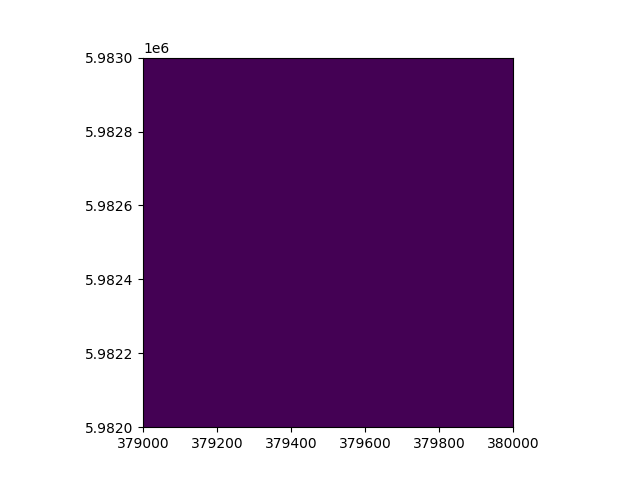

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True False ... False False False]
 [ True  True False ... False False False]
 [ True  True False ... False False False]]
[[1954    0]
 [1955    0]
 [1956    0]
 [1957    0]
 [1957    1]
 [1958    0]
 [1958    1]
 [1959    0]
 [1959    1]
 [1959    2]
 [1960    0]
 [1960    1]
 [1960    2]
 [1961    0]
 [1961    1]
 [1961    2]
 [1961    3]
 [1962    0]
 [1962    1]
 [1962    2]
 [1962    3]
 [1963    0]
 [1963    1]
 [1963    2]
 [1963    3]
 [1964    0]
 [1964    1]
 [1964    2]
 [1964    3]
 [1965    0]
 [1965    1]
 [1965    2]
 [1965    3]
 [1966    0]
 [1966    1]
 [1966    2]
 [1966    3]
 [1967    0]
 [1967    1]
 [1967    2]
 [1967    3]
 [1968    0]
 [1968    1]
 [1968    2]
 [1968    3]
 [1969    0]
 [1969    1]
 [1969    2]
 [1969    3]
 [1970    0]
 [1970    1]
 [1970    2]
 [1970    3]
 [1971    0]
 [1971    1]
 [1971    2]
 [1971  

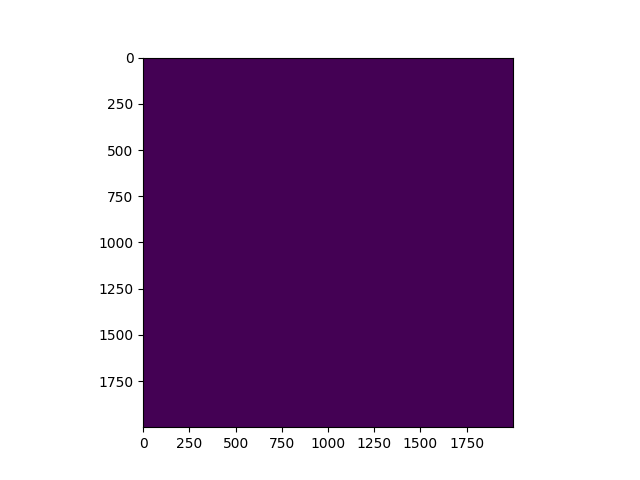

In [12]:
# %%timeit
for path in rasters:
    if "379_5982" in path.name:
        print(path.name)
        arr = has_voids_geometry_mask(path, boundary_filename, verbose=True)
        show(arr)

In [19]:
%%timeit
for path in rasters:
    print(path.name)
    print(has_voids_polygonize(path, boundary_filename, verbose=False))

UTM_12N_531_6040_18137_DTMHS.tif
True
UTM_12N_371_5963_18137_DTMHS.tif
True
UTM_12N_532_6042_18137_DTMHS.tif
True
UTM_12N_533_6042_18137_DTMHS.tif
True
UTM_12N_516_5945_18137_DTMHS.tif
True
UTM_12N_379_5982_18137_DTMHS.tif
True
UTM_12N_378_5981_18137_DTMHS.tif
True
UTM_12N_378_5982_18137_DTMHS.tif
True
UTM_12N_379_5981_18137_DTMHS.tif
True
UTM_12N_533_6041_18137_DTMHS.tif
True
UTM_12N_531_6040_18137_DTMHS.tif
True
UTM_12N_371_5963_18137_DTMHS.tif
True
UTM_12N_532_6042_18137_DTMHS.tif
True
UTM_12N_533_6042_18137_DTMHS.tif
True
UTM_12N_516_5945_18137_DTMHS.tif
True
UTM_12N_379_5982_18137_DTMHS.tif
True
UTM_12N_378_5981_18137_DTMHS.tif
True
UTM_12N_378_5982_18137_DTMHS.tif
True
UTM_12N_379_5981_18137_DTMHS.tif
True
UTM_12N_533_6041_18137_DTMHS.tif
True
UTM_12N_531_6040_18137_DTMHS.tif
True
UTM_12N_371_5963_18137_DTMHS.tif
True
UTM_12N_532_6042_18137_DTMHS.tif
True
UTM_12N_533_6042_18137_DTMHS.tif
True
UTM_12N_516_5945_18137_DTMHS.tif
True
UTM_12N_379_5982_18137_DTMHS.tif
True
UTM_12N_378_

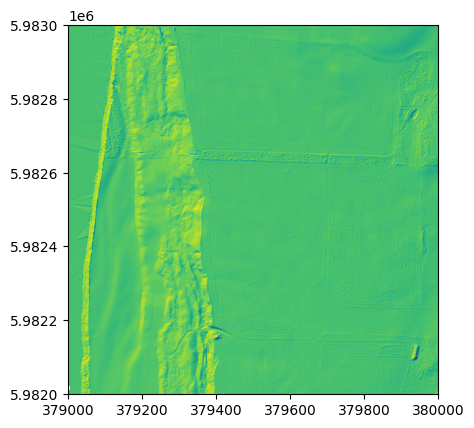

In [111]:
with rasterio.open("/home/ysebastien/git/enbridge-qc-voidfill/20241100 - Files for Sparkgeo/example voids/14808_Athabasca_Enbridge_Corridor_AMEC/DTMHS/UTM_12N/UTM_12N_379_5982_18137_DTMHS.tif") as src:
    show(src)